In [67]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

In [30]:
import numpy as np
import pandas as pd

In [46]:
from datetime import timedelta , datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [32]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect


In [33]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [34]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [35]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [36]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [37]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [38]:
inspector = inspect(engine)

In [39]:
inspector.get_table_names()

['measurement', 'station']

In [40]:
meas_col = inspector.get_columns('measurement')

for col in meas_col:
    print(col['name'], col['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [120]:
station_col = inspector.get_columns('station')
for col in station_col:
    print(col['name'],col['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [41]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
alldates = session.query(Measurement.date).group_by(Measurement.date).order_by(Measurement.date.desc()).all()



In [194]:
# Calculate the date 1 year ago from today
max_date = max(session.query(Measurement.date))
max_date = '08/23/17'
max_date = dt.strptime(max_date, "%m/%d/%y")
one_year_ago_date = max_date + timedelta(days=-365)
start_date_trip = '2016-09-01'
end_date_trp =  '2016-09-11'
print(f'The date one year ago from the max date in data {max_date}  is {one_year_ago_date}\nThe trip will start on {start_date_trip} and end on {end_date_trp}')



The date one year ago from the max date in data 2017-08-23 00:00:00  is 2016-08-23 00:00:00
The trip will start on 2016-09-01 and end on 2016-09-11


In [48]:
# Perform a query to retrieve the data and precipitation scores
df = pd.DataFrame(engine.execute("SELECT * from Measurement").fetchall())
# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = df.rename(columns = {0: "ID",1:"Station",2:"Date",3: "Prcp",4:"Tobs"})
# Sort the dataframe by date >> The data is already sorted by date
rain_df.head(10)


,ID,Station,Date,Prcp,Tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
5,6,USC00519397,2010-01-07,0.06,70.0
6,7,USC00519397,2010-01-08,0.00,64.0
7,8,USC00519397,2010-01-09,0.00,68.0
8,9,USC00519397,2010-01-10,0.00,73.0
9,10,USC00519397,2010-01-11,0.01,64.0


In [58]:
#Last 12 months
rain_df_L12M = rain_df.query('Date > "2016-08-22"')
rain_df_L12M.head()

,ID,Station,Date,Prcp,Tobs
2363,2364,USC00519397,2016-08-23,0.00,81.0
2364,2365,USC00519397,2016-08-24,0.08,79.0
2365,2366,USC00519397,2016-08-25,0.08,80.0
2366,2367,USC00519397,2016-08-26,0.00,79.0
2367,2368,USC00519397,2016-08-27,0.00,77.0


#We should fill the NAs in Prcp column since this will throw an error once we plot

In [163]:
#Find mean Prcp then fill the NaN with that number or we can use 0; 0 is probably better in this case

#mean_Prcp = rain_df_L12M['Prcp'].mean()
rain_df_L12M =   rain_df_L12M.fillna(0)
rain_df_L12M.head()

,ID,Station,Date,Prcp,Tobs
2363,2364,USC00519397,2016-08-23,0.00,81.0
2364,2365,USC00519397,2016-08-24,0.08,79.0
2365,2366,USC00519397,2016-08-25,0.08,80.0
2366,2367,USC00519397,2016-08-26,0.00,79.0
2367,2368,USC00519397,2016-08-27,0.00,77.0


In [151]:
# Rotate the xticks for the dates
years = mdates.YearLocator()
months = mdates.MonthLocator()
yearsFmt = mdates.DateFormatter('%Y')
#dates = mdates.date2num(rain_df_L12M['Date'])


#dates = rain_df_L12M[['Date']]


pandas.core.series.Series

TypeError: 361 is not a string

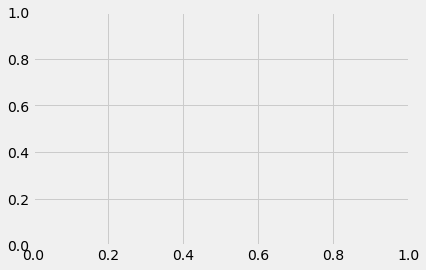

In [199]:
# Use Pandas Plotting with Matplotlib to plot the data
dates_ = rain_df_L12M['Date'].apply(lambda x: np.array(x))
plt.plot(dates_,rain_df_L12M['Prcp'])
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.xaxis.set_minor_locator(months)
#plt.bar(dates_,rain_df_L12M['Prcp'])
#rain_df_L12M['Prcp']




![precipitation](Images/precipitation.png)

In [137]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df_L12M.describe(include = 'all')

,ID,Station,Date,Prcp,Tobs
count,2231.000000,2231,2231,2231.000000,2231.000000
unique,NaN,8,367,NaN,NaN
top,NaN,USC00519397,2016-09-22,NaN,NaN
freq,NaN,361,7,NaN,NaN
mean,10154.178844,NaN,NaN,0.322403,74.718960
std,5606.082481,NaN,NaN,7.652259,7.617504
min,361.000000,NaN,NaN,0.000000,58.000000
25%,5286.500000,NaN,NaN,0.000000,72.000000
50%,8930.000000,NaN,NaN,0.010000,75.000000
75%,14750.500000,NaN,NaN,0.110000,78.000000


In [70]:
# How many stations are available in this dataset?
stations = len(rain_df.Station.unique())
stations_list = rain_df.Station.unique()

print(f'There are {stations} stations: {stations_list}')



There are 9 stations: ['USC00519397' 'USC00513117' 'USC00514830' 'USC00517948' 'USC00518838'
 'USC00519523' 'USC00519281' 'USC00511918' 'USC00516128']


In [81]:
# What are the most active stations?
# List the stations and the counts in descending order.
grouped = rain_df_L12M.groupby(by = 'Station').count().reset_index()
grouped.sort_values('Tobs', ascending = False)


,Station,ID,Date,Prcp,Tobs
5,USC00519397,361,361,359,361
4,USC00519281,352,352,352,352
2,USC00516128,349,349,328,349
0,USC00513117,343,343,343,343
6,USC00519523,337,337,314,337
1,USC00514830,305,305,265,305
3,USC00517948,183,183,60,183


In [131]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
df_MostActive = rain_df_L12M[rain_df_L12M['Station'] == 'USC00519397']
df_MostActive_MinTemp = df_MostActive['Tobs'].min()
df_MostActive_MaxTemp = df_MostActive['Tobs'].max()
df_Most_Active_AvgTemp = df_MostActive['Tobs'].mean()

print(f'For Station UCS00519397, the lowest temp was {df_MostActive_MinTemp}; \
the highest temp was {df_MostActive_MaxTemp} and the average temp was \
{df_Most_Active_AvgTemp}')

For Station UCS00519397, the lowest temp was 60.0; the highest temp was 87.0 and the average temp was 75.21052631578948


Text(0.5,1,'Histogram for Most Active Station')

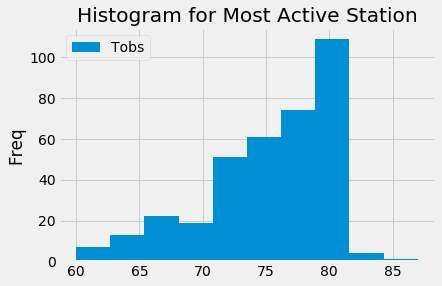

In [195]:
# Choose the station with the highest number of temperature observations.

# Query the last 12 months of temperature observation data for this station and 
#plot the results as a histogram
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.hist(df_MostActive['Tobs'])
handles, labels = ax.get_legend_handles_labels()
lgd =ax.legend(handles, labels, loc = 'upper left')
plt.ylabel('Freq')
plt.title('Histogram for Most Active Station')



## Optional Challenge Assignment

In [ ]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
